## Método de análise

Para estimar uma medida de sensibilidade a surpresas inflacionárias, devemos verificar o impacto que **variações nas expectativas para o ano corrente provocam sobre as expectativas para prazos mais longos**. Na presença de expectativas bem ancoradas, deve haver baixa relação (co-movimento) entre as expectativas de inflação de longo prazo e as de curto prazo, em que estas últimas capturariam surpresas inflacionárias.

Em termos econométricos, essa sensibilidade é calculada a partir do coeficiente $\beta$, de acordo com a equação abaixo:

$$\Delta \pi_t^{e,h} = \alpha + \beta^h \Delta \pi_t^{e,0} + \epsilon_t$$

onde $\Delta \pi_{t}^{e,h}$ é a variação $\Delta$ da expectativa de inflação $\pi^e$ no tempo $t$ para o horizonte $h = 1, ... , 4$, em anos, para o qual foram formadas as expectativas.

Portanto, quanto maior o coeficiente $\beta$ menos ancoradas as expectativas, ou seja, maior a resposta das expectativas de longo prazo a surpresas inflacionárias. Como o interesse é na evolução deste coeficiente ao longo do tempo, as estimações são realizadas a partir de janelas móveis de 60 meses.

### 1. Carregamento das bibliotecas

In [130]:
from bcb import Expectativas
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 2.  Coleta e Tratamento de dados

Vamos coletar as expectativas anuais do IPCA. Em seguida, devemos definir os horizontes com base na data de referência. Retiramos a média do valor da mediana para os respectivos meses agrupados por horizontes. E por fim, obtemos o delta de cada horizonte, isto é, a diferença entre o valor do horizonte no tempo t e do tempo t-1.

In [131]:
# Instância a classe de Expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Mercado Anuais
exp_ipca_endpoint = em.get_endpoint("ExpectativasMercadoAnuais")

# Expectativa média do IPCA - tx. anual (Expectativas)
exp_ipca_raw = (
    exp_ipca_endpoint
    .query()
    .filter(exp_ipca_endpoint.baseCalculo == 0,
            exp_ipca_endpoint.Indicador == "IPCA",
            exp_ipca_endpoint.Data >= "2002-01-01")
    .collect()
    )

In [132]:
# Realiza a filtragem e define os horizontes
exp_ipca_h = (
    exp_ipca_raw
    .filter(items = ["Data", "DataReferencia", "Mediana"], axis = "columns")
    .assign(
      Data = lambda x : pd.to_datetime(x.Data),
      DataReferencia = lambda x: x.DataReferencia.astype(int),
      h = lambda x: np.select([
        x["Data"].dt.year == x["DataReferencia"],
        x["Data"].dt.year == x["DataReferencia"] - 1,
        x["Data"].dt.year == x["DataReferencia"] - 2,
        x["Data"].dt.year == x["DataReferencia"] - 3,
        x["Data"].dt.year == x["DataReferencia"] - 4
        ],
        ["h0", "h1", "h2", "h3", "h4"]
        ),
      Year = lambda x: x["Data"].dt.year,
      Month = lambda x: x["Data"].dt.month
    )
    .query("h != '0'")
)

In [133]:
# Agrega dados
expec_ipca = (
     exp_ipca_h
    .assign(data = lambda x: x.Data.dt.to_period(freq = "M").dt.to_timestamp())
    .groupby(by = ["data", "h"], as_index = False) 
    .agg(Mediana = ("Mediana", "mean"))
  )

In [134]:
# Calcula o delta (diferença do tempo t com o tempo t-1)
expec_ipca_diff = (
    expec_ipca
    .pivot(index = "data", columns = "h", values = "Mediana")
    .diff()
    .dropna()
  )

### 3. Criação do Modelo

Para obter o coeficiente $\beta$ em janelas deslizantes de 60 meses será necessário utilizar a função `RollingOLS` da biblioteca `statsmodels`.

Em relação a especificação, podemos obter a surpresa inflacionária para os diferentes horizontes, portanto, para obter o resultado de todas as combinações possíveis, usaremos um `for loop` para as fórmulas. 

In [135]:
# Define variável independente e variáveis dependentes
X = expec_ipca_diff["h0"]
Y_cols = ["h1", "h2", "h3", "h4"]

# Define tamanho da janela de regressão
k = 60

# Cria lista para armazenar os resultados das regressões
results = []

# Loop para ajustar os modelos de regressão
for col in Y_cols:
    # Define fórmula da regressão
    formula = f"{col} ~ h0"
    
    # Cria o objeto RollingOLS
    model_rolling = RollingOLS.from_formula(
      formula = formula,
      data = expec_ipca_diff,
      window = k
      )
    
    # Calcula as rolling regressions
    rolling_res = model_rolling.fit()

    # Salva os resultados das regressões
    results.append(rolling_res.params)

# Juntar os resultados das regressões em um único dataframe
results_df = pd.concat(results, axis = 0, keys = Y_cols)

In [136]:

# Captura somente o beta da regressão
# Assuming results_df is already defined
beta = (
    results_df
    .reset_index()
    .rename(columns={"level_0": "variables", "h0": "beta"})
    .dropna()
    .filter(items=["data", "variables", "beta"], axis="columns")
    .assign(
        variables=lambda x: np.select(
            [
                x.variables == "h1",
                x.variables == "h2",
                x.variables == "h3",
                x.variables == "h4"
            ],
            [
                "Expectativa 1 ano",
                "Expectativa 2 anos",
                "Expectativa 3 anos",
                "Expectativa 4 anos"
            ],
            default=x.variables
        )
    )
)
beta_data = pd.DataFrame(beta)
beta_data

,data,variables,beta
59,2007-01-01,Expectativa 1 ano,0.602037
60,2007-02-01,Expectativa 1 ano,0.602117
61,2007-03-01,Expectativa 1 ano,0.602447
62,2007-04-01,Expectativa 1 ano,0.605620
63,2007-05-01,Expectativa 1 ano,0.605380
...,...,...,...
1071,2024-02-01,Expectativa 4 anos,0.008225
1072,2024-03-01,Expectativa 4 anos,0.008225
1073,2024-04-01,Expectativa 4 anos,0.008235
1074,2024-05-01,Expectativa 4 anos,0.008286


In [161]:
beta['data'].max()

Timestamp('2024-06-01 00:00:00')

### 4. Visualização de dados

Enfim podemos visualizar o coeficiente $\beta$ para cada horizonte ao longo de diferentes mandatos de presidentes do Banco Central e realizar uma análise.

C:\Users\pedro\AppData\Local\Temp\ipykernel_34936\3525615680.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


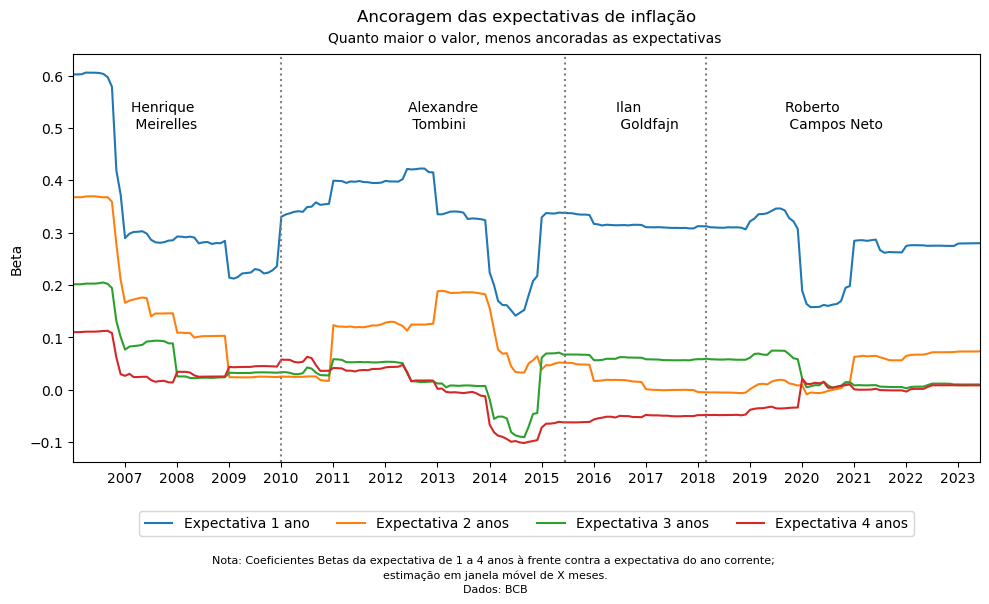

In [163]:
# Configurando as dimensões do gráfico
plt.figure(figsize=(10, 6))

# Agrupando dados por variável e plotando cada linha com uma cor diferente
for label, df in beta.groupby('variables'):
    plt.plot(df['data'], df['beta'], label=label)

# Definindo os intervalos e formatos dos rótulos do eixo x
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(pd.date_range(start=beta['data'].min(), end=beta['data'].max(), freq='1Y'))

# Adicionando linhas verticais
vline_dates = ["2010-12-31", "2016-06-09", "2019-02-28"]
for vline_date in vline_dates:
    plt.axvline(pd.to_datetime(vline_date), color='gray', linestyle='dotted')

# Adicionando anotações
annotations = [
    ("2008-02-09", 0.5, "Henrique \n Meirelles"),
    ("2013-06-09", 0.5, "Alexandre \n Tombini"),
    ("2017-06-06", 0.5, "Ilan \n Goldfajn"),
    ("2020-09-01", 0.5, "Roberto \n Campos Neto"),
]

for (x, y, label) in annotations:
    plt.text(pd.to_datetime(x), y, label, fontsize=10)

# Adicionando título e subtítulo
plt.title("Ancoragem das expectativas de inflação", y=1.06)
plt.suptitle("Quanto maior o valor, menos ancoradas as expectativas", fontsize=10, y=0.885,x = 0.53)

# Adicionando legendas e rótulos dos eixos
plt.ylabel("Beta")
plt.xlabel("")
plt.xlim(pd.to_datetime(beta['data'].min()), pd.to_datetime(beta['data'].max()))
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.figtext(0.5, -0.05, "Nota: Coeficientes Betas da expectativa de 1 a 4 anos à frente contra a expectativa do ano corrente; \nestimação em janela móvel de X meses.\nDados: BCB", ha="center", fontsize=8, linespacing=1.5)

# Exibindo o gráfico
plt.tight_layout()
plt.show()